<a href="https://colab.research.google.com/github/victor-hro/movie-recommender/blob/main/heur%C3%ADsticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Filmes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [320]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Conjunto de dados: MovieLens

### download

In [321]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip ml-latest-small.zip

In [322]:
df_movies = pd.read_csv('/content/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')

In [323]:
# utilizando o próprio ID do filme como índice
df_movies.set_index('movieId', inplace=True)
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [324]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Primeira Heurística: recomendação dos filmes mais populares

## Distribuição de frequência de notas

In [325]:
total_ratings = df_ratings['movieId'].value_counts()
total_ratings

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

In [326]:
# agrupando por índice
df_movies['total_ratings'] = total_ratings
df_movies

,title,genres,total_ratings
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0
2,Jumanji (1995),Adventure|Children|Fantasy,110.0
3,Grumpier Old Men (1995),Comedy|Romance,52.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0
5,Father of the Bride Part II (1995),Comedy,49.0
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1.0
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,1.0
193585,Flint (2017),Drama,1.0


In [327]:
# analisando do maior para o menor número de votos
df_movies.sort_values('total_ratings', ascending=False).head(10)

,title,genres,total_ratings
movieId,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0
110,Braveheart (1995),Action|Drama|War,237.0
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0


Poderíamos até indicar esses 10 filmes para qualquer pessoa, baseando apenas na heurística de recomendação de filmes mais votados. Porém há um problema nessa análise: os filmes podem ter um maior número de votos, mas as notas também são boas?

Outra questão é relacionada ao comportamento em grupos de internet. Pode haver a possibilidade de comunidades de um nicho se unirem para votar em determinado filme, subindo ele para a lista de mais votados.

In [328]:
# agrupando por notas
average_ratings = df_ratings.groupby('movieId').rating.mean()
average_ratings

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [329]:
df_movies['average_ratings'] = average_ratings
df_movies['average_ratings'] = df_movies['average_ratings'].apply(lambda x: round(x,2))
df_movies.head()

,title,genres,total_ratings,average_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,3.92
2,Jumanji (1995),Adventure|Children|Fantasy,110.0,3.43
3,Grumpier Old Men (1995),Comedy|Romance,52.0,3.26
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0,2.36
5,Father of the Bride Part II (1995),Comedy,49.0,3.07


In [330]:
# analisando do maior para o menor número de votos, agora com as notas
top_10_most_voted = df_movies.sort_values('total_ratings', ascending=False).head(10)
top_10_most_voted

,title,genres,total_ratings,average_ratings
movieId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0,4.16
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0,4.20
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0,4.16
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0,4.19
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0,4.23
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0,3.75
110,Braveheart (1995),Action|Drama|War,237.0,4.03
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0,3.97


<Figure size 576x432 with 0 Axes>

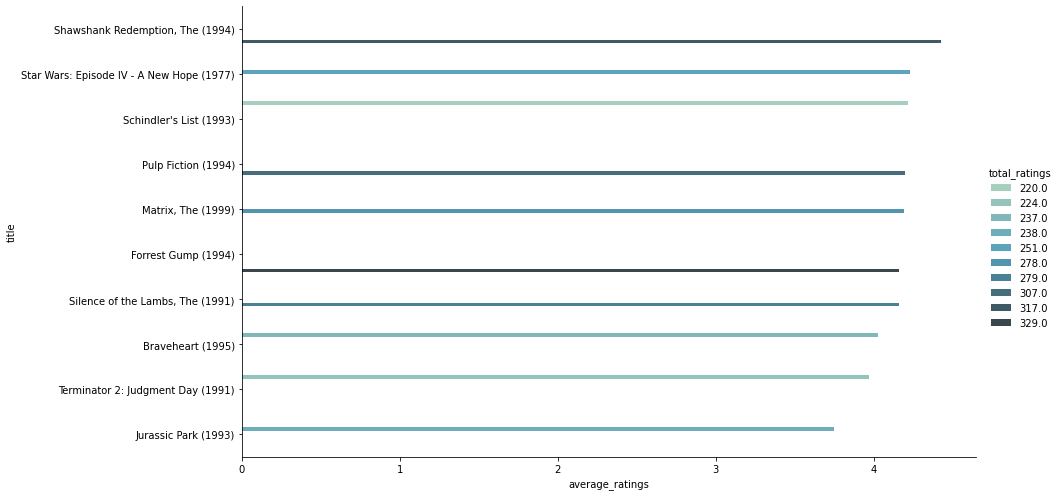

In [331]:
# agrupando as 10 maiores notas
plt.figure(figsize=(8,6))
sns.catplot(
    data=top_10_most_voted[['title','total_ratings', 'average_ratings']],
    x='average_ratings',
    y='title',
    kind='bar',
    orient='h',
    palette='GnBu_d',
    aspect=2,
    height=7,
    hue='total_ratings',
    order = top_10_most_voted[['title', 'total_ratings', 'average_ratings']].sort_values('average_ratings', ascending=False).title.values
)

podemos ver que filmes como o Jurassic Park foram bem votados, porém não apresentam uma nota tão alta como os demais.
Schindler's List foi um dos filmes menos populares em votos e teve uma das maiores notas médias.

# Segunda Heurística: recomendação dos filmes com maior nota média.

In [332]:
df_movies.sort_values('average_ratings', ascending=False).head(10)

,title,genres,total_ratings,average_ratings
movieId,,,,
69860,Eichmann (2007),Drama|War,1.0,5.0
145994,Formula of Love (1984),Comedy,1.0,5.0
141816,12 Chairs (1976),Adventure|Comedy,1.0,5.0
26366,Harlan County U.S.A. (1976),Documentary,1.0,5.0
95311,Presto (2008),Animation|Children|Comedy|Fantasy,1.0,5.0
5088,"Going Places (Valseuses, Les) (1974)",Comedy|Crime|Drama,1.0,5.0
95175,Front of the Class (2008),Drama,1.0,5.0
26401,Last Hurrah for Chivalry (Hao xia) (1979),Action|Drama,1.0,5.0
5059,Little Dieter Needs to Fly (1997),Documentary,1.0,5.0


Há um grande problema em utilizar essa heurística. Não podemos definir que um filme é muito bom apenas pelo valor da nota média. Estamos vendo que, para nota 5, os top 10 filmes tiveram apenas 1 voto.

Outra hipótese que podemos levar em conta é relacionada ao nicho de cada filme. Talvez o filme pode ser tão específico para um nicho que poucas pessoas votam, porém podem votar com notas altas.

possível solução: vamos filtrar o total de votos por um valor N para ter um melhor controle dessa métrica:

In [348]:
ratings_over_50 = df_movies.query("total_ratings >= 50").sort_values('average_ratings', ascending=False)
ratings_over_50

,title,genres,total_ratings,average_ratings
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
858,"Godfather, The (1972)",Crime|Drama,192.0,4.29
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,97.0,4.27
1276,Cool Hand Luke (1967),Drama,57.0,4.27
2959,Fight Club (1999),Action|Crime|Drama|Thriller,218.0,4.27
...,...,...,...,...
172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,53.0,2.68
173,Judge Dredd (1995),Action|Crime|Sci-Fi,62.0,2.67
432,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western,55.0,2.65


Ainda não parece interessante para nossos propósitos. Pode funcionar, porém também pode ter um viés relacionado ao nicho

# Terceira Heurística: recomendação baseada em similaridade de gênero.

dentre os filmes com votos acima de 50, vamos escolher um filme e analisar os filmes com gêneros parecidos.

Vamos supoer que escolhermos assistir algum filme do Harry Potter

In [354]:
ratings_over_50[ratings_over_50.title.str.contains('Harry Potter')]

,title,genres,total_ratings,average_ratings
movieId,,,,
8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,93.0,3.91
88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,50.0,3.91
69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,58.0,3.89
54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,58.0,3.86
40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,71.0,3.82
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,107.0,3.76
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,102.0,3.60


Harry Potter and the Chamber of Secrets (2002) foi escolhido

In [356]:
movies_watched = df_movies.query("title == 'Harry Potter and the Chamber of Secrets (2002)'")
movies_watched

,title,genres,total_ratings,average_ratings
movieId,,,,
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,102.0,3.6


In [364]:
adventure_fantasy = ratings_over_50.query("genres=='Adventure|Fantasy'")
adventure_fantasy.drop(movies_watched.index, errors='ignore', inplace=True)
adventure_fantasy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,genres,total_ratings,average_ratings
movieId,,,,
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,198.0,4.11
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,188.0,4.02


Quando a pessoa acaba de ver harry potter, os dois filmes de Lord of the Rings podem ser recomendados para assistir posteriormente.

# Collaborative Filtering x Content Based Filtering